In [2]:
import os
import pandas as pd
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
from tqdm import tqdm
import itk
import SimpleITK as sitk
from typing import List
import psutil
import time
from tissue_model_segmentation import TissueModelSegmentation

## Utility functions

In [3]:
def readNiftiImage(file_path):
        # Read Nifti image
        try:
            niftiImage = nib.load(file_path).get_fdata()
            return niftiImage, nib.load(file_path).affine
        except Exception as e:
            print(f"Error reading NIFTI image from {file_path}: {str(e)}")           


def get_file_paths(folder_path):
    file_paths = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".nii.gz"):
                file_paths.append(os.path.join(root, file))
    return sorted(file_paths)

# Evaluation

def calculate_dice_scores(pred, gt, labels=[1, 2, 3]):
        dice_scores = {}
        for label in labels:
            pred_count = np.sum(pred == label)
            gt_count = np.sum(gt == label)
            intersection = np.sum((pred == label) & (gt == label))
            if pred_count + gt_count == 0:
                dice_score = 1.0  # Perfect match if label is absent in both
            else:
                dice_score = 2 * intersection / (pred_count + gt_count)
            dice_scores[label] = dice_score
        return dice_scores
    
# Function to create a color-coded boxplot of Dice scores without black background
def plot_dice_score_boxplot(metrics_df):

    # Reshape the data for Seaborn
    melted_df = metrics_df.melt(id_vars=['Image'], value_vars=['CSF', 'WM', 'GM'],
                                        var_name='Tissue', value_name='Dice Score')

    # Define softer colors for each tissue type
    tissue_palette = {'CSF': '#a8dadc', 'WM': '#457b9d', 'GM': '#1d3557'}

    # Plot with Seaborn
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=melted_df, x='Tissue', y='Dice Score', palette=tissue_palette)
    plt.title("Dice Score Distribution for CSF, WM, and GM Using Tissue Models")
    plt.ylabel("Dice Score")
    plt.xlabel("Tissue Type")

    # Add legend
    legend_handles = [mpatches.Patch(color=color, label=tissue) for tissue, color in tissue_palette.items()]
    plt.legend(handles=legend_handles, title="Tissue Types")

    plt.show()

## 1. Segment using label propagation and atlas registration

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

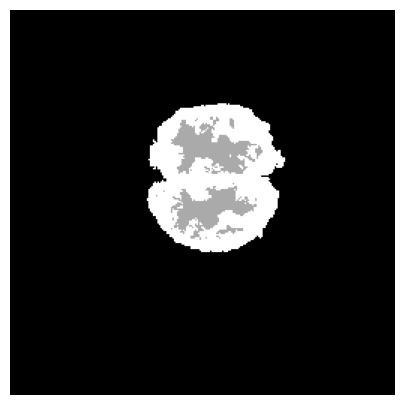

In [3]:
topo_atlas, _ = readNiftiImage('Atlas/topo_atlas.nii.gz')

# plot the atlas
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(topo_atlas[:, 50, :], cmap='gray')
plt.axis('off')

In [4]:
def check_memory():
    """Check memory usage for debugging."""
    process = psutil.Process()
    mem_info = process.memory_info()
    print(f"Memory Usage: {mem_info.rss / (1024 ** 2):.2f} MB")  # Memory in MB

def show_results(fixed_image, gt_label, warped_atlas, modality='T1', i=0, slice_idx=150):
    """Visualize the fixed image, ground truth label, and warped topological atlas."""
    fixed_image_array = itk.GetArrayFromImage(fixed_image) if isinstance(fixed_image, itk.Image) else fixed_image
    if fixed_image_array.ndim == 3:
        slice_idx = min(slice_idx, fixed_image_array.shape[0] - 1)
        fixed_slice = fixed_image_array[slice_idx, :, :]
        gt_slice = gt_label[slice_idx, :, :]
        atlas_slice = warped_atlas[slice_idx, :, :]
    else:
        raise ValueError("Expected 3D image arrays for fixed_image, gt_label, and warped_atlas.")
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    titles = [f"Fixed Image (Modality: {modality})", "Ground Truth Label", "Warped Topological Atlas"]
    images = [fixed_slice, gt_slice, atlas_slice]
    for ax, img, title in zip(axes, images, titles):
        ax.imshow(img, cmap='gray')
        ax.set_title(title)
        ax.axis('off')
    plt.suptitle(f"Registration Result for Image Index {i}, Slice {slice_idx}")
    plt.show()

def perform_label_propagation(test_image_files: List[str], mask_files: List[str], mean_volume, topological_atlas) -> None:
    """Perform label propagation on test images using elastix registration."""
    # Convert mean_volume and topological_atlas to ITK format if they are not already
    if isinstance(mean_volume, np.ndarray):
        mean_volume = itk.image_from_array(mean_volume.astype(np.float32))
    if isinstance(topological_atlas, np.ndarray):
        topological_atlas = itk.image_from_array(topological_atlas.astype(np.float32))

    # Ensure output directory exists for logs
    output_directory = "elastix_logs-mni"
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    output_segmentation_dir = "lp-segmentations-mni"
    if not os.path.exists(output_segmentation_dir):
        os.makedirs(output_segmentation_dir)

    with tqdm(total=len(test_image_files), desc="Registration Progress") as pbar:
        for i, (image_file, mask_file) in enumerate(zip(test_image_files, mask_files)):
            print(f"Processing image {i+1}/{len(test_image_files)}: {image_file}")
            check_memory()  # Check memory usage before each registration step
            
            # Load fixed image and ground truth label
            fixed_image = itk.imread(image_file, itk.F)
            gt_label = itk.imread(mask_file, itk.F)
            
            # Setup registration parameters
            parameter_object = itk.ParameterObject.New()
            parameter_object.AddParameterFile("Parameter_Files/Par0010affine.txt")
            parameter_object.AddParameterFile("Parameter_Files/Par0010bspline.txt")
            
            # Perform registration
            result_image, result_transform_parameters = itk.elastix_registration_method(
                fixed_image, mean_volume,
                parameter_object=parameter_object,
                log_to_console=True,
                log_to_file=True,
                output_directory=output_directory
            )
            
            # Print registration info
            print(f"Completed registration for: {os.path.basename(image_file)}")
            
            # Transform atlas
            result_transform_parameters.SetParameter("ResampleInterpolator", ["FinalNearestNeighborInterpolator"])
            topological_atlas_warped = itk.transformix_filter(topological_atlas, result_transform_parameters)
            
            # Show results
            show_results(
                fixed_image, 
                itk.GetArrayFromImage(gt_label), 
                itk.GetArrayFromImage(topological_atlas_warped), 
                modality='T1', 
                i=i, 
                slice_idx=150
            )
            
            # Save the segmented image
            topological_atlas_warped_sitk = sitk.GetImageFromArray(itk.GetArrayFromImage(topological_atlas_warped))
            topological_atlas_warped_sitk.CopyInformation(sitk.ReadImage(image_file))
            output_path = os.path.join(output_segmentation_dir, f'{os.path.splitext(os.path.basename(image_file))[0]}_segmented.nii.gz')
            sitk.WriteImage(topological_atlas_warped_sitk, output_path)

            pbar.update(1)
            time.sleep(1)  # Short sleep to observe changes in memory usage

In [ ]:
# apply label propagation

test_image_files = get_file_paths("test_set\\testing-images")
test_image_mask_files = get_file_paths("test_set\\testing-labels")
mean_volume, _ = readNiftiImage('Atlas\\mean_image.nii.gz')
topological_atlas, _ = readNiftiImage('Atlas\\topo_atlas.nii.gz')

In [ ]:
# Take the last 2 images for testing
test_image_files = test_image_files[4:6]
test_image_mask_files = test_image_mask_files[4:6]

In [ ]:
test_image_files

In [ ]:
test_image_mask_files

In [ ]:
print("Test image files:", test_image_files)
print("Test image mask files:", test_image_mask_files)


In [ ]:
# show mean_volume
plt.imshow(mean_volume[:, 50, :], cmap='gray')

In [ ]:
# import os

# test_image_files = [os.path.join("test_set", "testing-images", "1019.nii.gz")]
# test_image_mask_files = [os.path.join("test_set", "testing-labels", "1019_3C.nii.gz")]


In [ ]:
# exceptions are 1019, 1023, 1039

In [ ]:
# perform label propagation
perform_label_propagation(test_image_files, test_image_mask_files, mean_volume, topological_atlas)

In [4]:
# Test the label propagation results
lp_mask_files = get_file_paths("lp-segmentations")
test_gt_mask_files = get_file_paths("test_set\\testing-labels")
# exceptions are 1019, 1023, 1039
test_gt_mask_files = [file for file in test_gt_mask_files if '1019' not in file and '1023' not in file and '1039' not in file]
print("Test image files:", test_gt_mask_files)

Test image files: ['test_set\\testing-labels\\1003_3C.nii.gz', 'test_set\\testing-labels\\1004_3C.nii.gz', 'test_set\\testing-labels\\1005_3C.nii.gz', 'test_set\\testing-labels\\1018_3C.nii.gz', 'test_set\\testing-labels\\1024_3C.nii.gz', 'test_set\\testing-labels\\1025_3C.nii.gz', 'test_set\\testing-labels\\1038_3C.nii.gz', 'test_set\\testing-labels\\1101_3C.nii.gz', 'test_set\\testing-labels\\1104_3C.nii.gz', 'test_set\\testing-labels\\1107_3C.nii.gz', 'test_set\\testing-labels\\1110_3C.nii.gz', 'test_set\\testing-labels\\1113_3C.nii.gz', 'test_set\\testing-labels\\1116_3C.nii.gz', 'test_set\\testing-labels\\1119_3C.nii.gz', 'test_set\\testing-labels\\1122_3C.nii.gz', 'test_set\\testing-labels\\1125_3C.nii.gz', 'test_set\\testing-labels\\1128_3C.nii.gz']


In [5]:
# Calculate Dice scores
metrics_lp = {'Image': [], 'CSF': [], 'WM': [], 'GM': []}

for lp_mask_file, gt_mask_file in zip(lp_mask_files, test_gt_mask_files):
    # Extract the filename (without the directory path) for each lp_mask_file
    image_name = os.path.basename(lp_mask_file)
    
    # Load the masks
    lp_mask, _ = readNiftiImage(lp_mask_file)
    gt_mask, _ = readNiftiImage(gt_mask_file)
    
    # Calculate Dice scores
    dice_scores = calculate_dice_scores(lp_mask, gt_mask, labels=[1, 2, 3])
    
    # Append the results to the metrics dictionary
    metrics_lp['Image'].append(image_name)  # Save the exact filename
    metrics_lp['CSF'].append(dice_scores[1])
    metrics_lp['WM'].append(dice_scores[2])
    metrics_lp['GM'].append(dice_scores[3])
    
# Convert the metrics dictionary to a DataFrame
metrics_lp_df = pd.DataFrame(metrics_lp)

In [6]:
metrics_lp_df

,Image,CSF,WM,GM
0,1003.nii_segmented.nii.gz,0.028735,0.568325,0.563839
1,1004.nii_segmented.nii.gz,0.107295,0.570563,0.560461
2,1005.nii_segmented.nii.gz,0.176123,0.535631,0.551041
3,1018.nii_segmented.nii.gz,0.161603,0.569766,0.586574
4,1024.nii_segmented.nii.gz,0.109945,0.566198,0.583185
5,1025.nii_segmented.nii.gz,0.150859,0.536420,0.573280
6,1038.nii_segmented.nii.gz,0.149177,0.566793,0.578299
7,1101.nii_segmented.nii.gz,0.339319,0.578639,0.567051
8,1104.nii_segmented.nii.gz,0.234641,0.582602,0.564565
9,1107.nii_segmented.nii.gz,0.009311,0.539749,0.532283


In [8]:
# save the cv results
metrics_lp_df.to_csv('Result\\LP\\metrics_lp_df.csv', index=False)



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



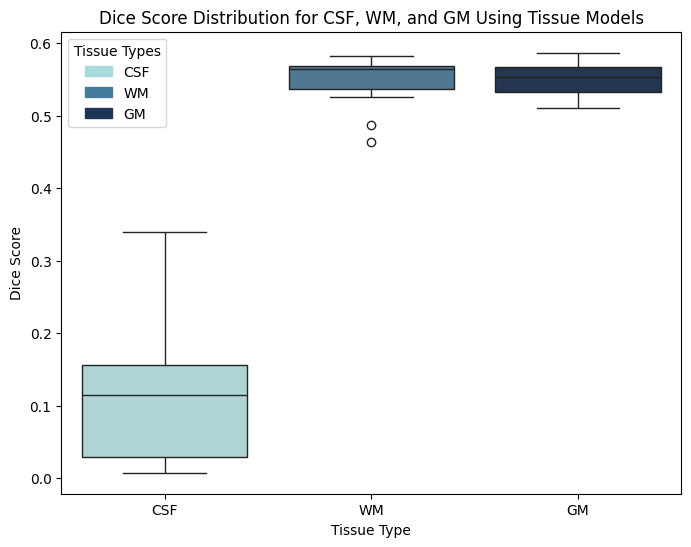

In [7]:
plot_dice_score_boxplot(metrics_lp_df)

### Using MNI Atlas 

In [11]:
# Load MNI atlas
mni_mean_volume, _ = readNiftiImage('MNI Atlas/template.nii.gz')

# Load the atlas and get the three tissue types
mni_atlas, _ = readNiftiImage('MNI Atlas/atlas.nii.gz')

In [13]:
mni_atlas.shape

(182, 218, 182, 4)

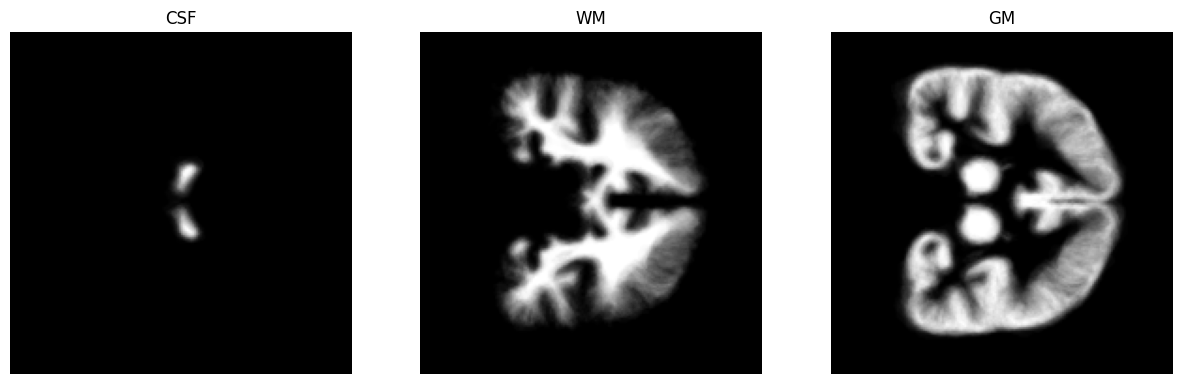

In [19]:
# take the second index of last dimension
mni_csf = mni_atlas[:, :, :, 1]
mni_wm = mni_atlas[:, :, :, 3]
mni_gm = mni_atlas[:, :, :, 2]

# Show the MNI atlas
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
titles = ['CSF', 'WM', 'GM']
images = [mni_csf, mni_wm, mni_gm]
for ax, img, title in zip(axes, images, titles):
    ax.imshow(img[:, 100, :], cmap='gray')
    ax.set_title(title)
    ax.axis('off')

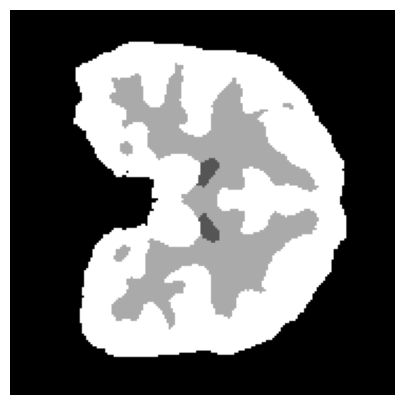

In [26]:
# Make the topological atlas using mni_csf, mni_wm, mni_gm

# Stack the images and find the argmax along the first dimension
stacked_images = np.array([mni_csf, mni_wm, mni_gm])
topological_atlas = np.argmax(stacked_images, axis=0)+1

# Set background to 0 where all values are zero across the stacked images
topological_atlas[np.all(stacked_images == 0, axis=0)] = 0

# Show the topological atlas
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(topological_atlas[:, 100, :], cmap='gray')
plt.axis('off')

# convert to float32
topological_atlas = topological_atlas.astype(np.float32)

# Save the topological atlas with affine information from the MNI atlas
nib.save(nib.Nifti1Image(topological_atlas, nib.load('MNI Atlas/atlas.nii.gz').affine), 'MNI Atlas/topo_atlas.nii.gz')

In [5]:
# apply label propagation

test_image_files = get_file_paths("test_set\\testing-images")
test_gt_mask_files = get_file_paths("test_set\\testing-labels")
mean_volume, _ = readNiftiImage('MNI Atlas\\template.nii.gz')
topological_atlas, _ = readNiftiImage('MNI Atlas\\topo_atlas.nii.gz')

In [6]:
test_gt_mask_files = [file for file in test_gt_mask_files if '1019' not in file and '1023' not in file and '1039' not in file]
test_image_files = [file for file in test_image_files if '1019' not in file and '1023' not in file and '1039' not in file]
print("Test image files:", test_image_files)
print("Test image mask files:", test_gt_mask_files)

Test image files: ['test_set\\testing-images\\1003.nii.gz', 'test_set\\testing-images\\1004.nii.gz', 'test_set\\testing-images\\1005.nii.gz', 'test_set\\testing-images\\1018.nii.gz', 'test_set\\testing-images\\1024.nii.gz', 'test_set\\testing-images\\1025.nii.gz', 'test_set\\testing-images\\1038.nii.gz', 'test_set\\testing-images\\1101.nii.gz', 'test_set\\testing-images\\1104.nii.gz', 'test_set\\testing-images\\1107.nii.gz', 'test_set\\testing-images\\1110.nii.gz', 'test_set\\testing-images\\1113.nii.gz', 'test_set\\testing-images\\1116.nii.gz', 'test_set\\testing-images\\1119.nii.gz', 'test_set\\testing-images\\1122.nii.gz', 'test_set\\testing-images\\1125.nii.gz', 'test_set\\testing-images\\1128.nii.gz']
Test image mask files: ['test_set\\testing-labels\\1003_3C.nii.gz', 'test_set\\testing-labels\\1004_3C.nii.gz', 'test_set\\testing-labels\\1005_3C.nii.gz', 'test_set\\testing-labels\\1018_3C.nii.gz', 'test_set\\testing-labels\\1024_3C.nii.gz', 'test_set\\testing-labels\\1025_3C.nii.g

In [7]:
# perform label propagation
perform_label_propagation(test_image_files, test_gt_mask_files, mean_volume, topological_atlas)

Registration Progress:   0%|          | 0/17 [00:00<?, ?it/s]

Processing image 1/17: test_set\testing-images\1003.nii.gz
Memory Usage: 481.19 MB


: 

## 2. Segmentation using Tissue Models

In [3]:
# import TissueModel.csv
tissue_models = pd.read_csv('TissueModel.csv')

tissue_models.head()

,CSF,WM,GM
0,0.991473,0.000995,0.007532
1,0.991356,0.000999,0.007645
2,0.991123,0.001006,0.007871
3,0.990774,0.001018,0.008209
4,0.990311,0.001033,0.008656


In [4]:
tissue_models.shape

(255, 3)

In [5]:
tissue_model_map = np.argmax(tissue_models.values, axis=1) + 1

In [6]:
vec_images = []
vec_gt = []

for image_path in get_file_paths('test_set\\testing-images'):
    print(image_path)
    image, _ = readNiftiImage(image_path)
    vec_images.append(image)

for mask_path in get_file_paths('test_set\\testing-labels'):
    print(mask_path)
    gt, _ = readNiftiImage(mask_path)
    vec_gt.append(gt)

test_set\testing-images\1003.nii.gz
test_set\testing-images\1004.nii.gz
test_set\testing-images\1005.nii.gz
test_set\testing-images\1018.nii.gz
test_set\testing-images\1019.nii.gz
test_set\testing-images\1023.nii.gz
test_set\testing-images\1024.nii.gz
test_set\testing-images\1025.nii.gz
test_set\testing-images\1038.nii.gz
test_set\testing-images\1039.nii.gz
test_set\testing-images\1101.nii.gz
test_set\testing-images\1104.nii.gz
test_set\testing-images\1107.nii.gz
test_set\testing-images\1110.nii.gz
test_set\testing-images\1113.nii.gz
test_set\testing-images\1116.nii.gz
test_set\testing-images\1119.nii.gz
test_set\testing-images\1122.nii.gz
test_set\testing-images\1125.nii.gz
test_set\testing-images\1128.nii.gz
test_set\testing-labels\1003_3C.nii.gz
test_set\testing-labels\1004_3C.nii.gz
test_set\testing-labels\1005_3C.nii.gz
test_set\testing-labels\1018_3C.nii.gz
test_set\testing-labels\1019_3C.nii.gz
test_set\testing-labels\1023_3C.nii.gz
test_set\testing-labels\1024_3C.nii.gz
test_se

Dice Score Table:
Boxplot of Dice Scores:




Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



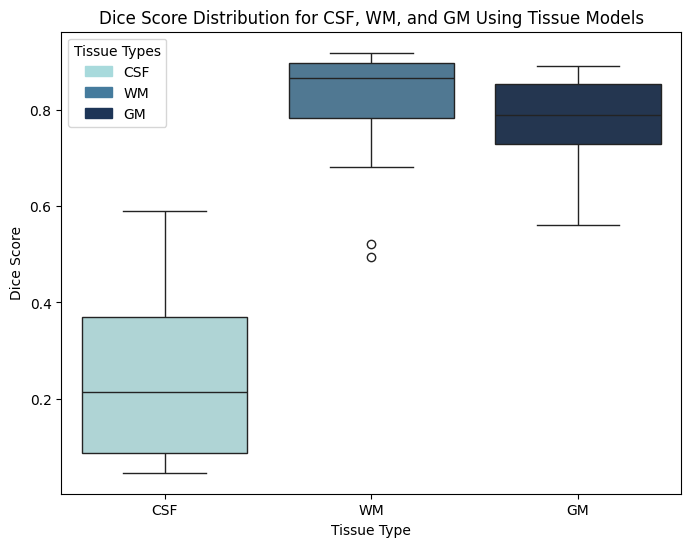

3x3 Grid Comparison of Ground Truth and Predicted Segmentations:


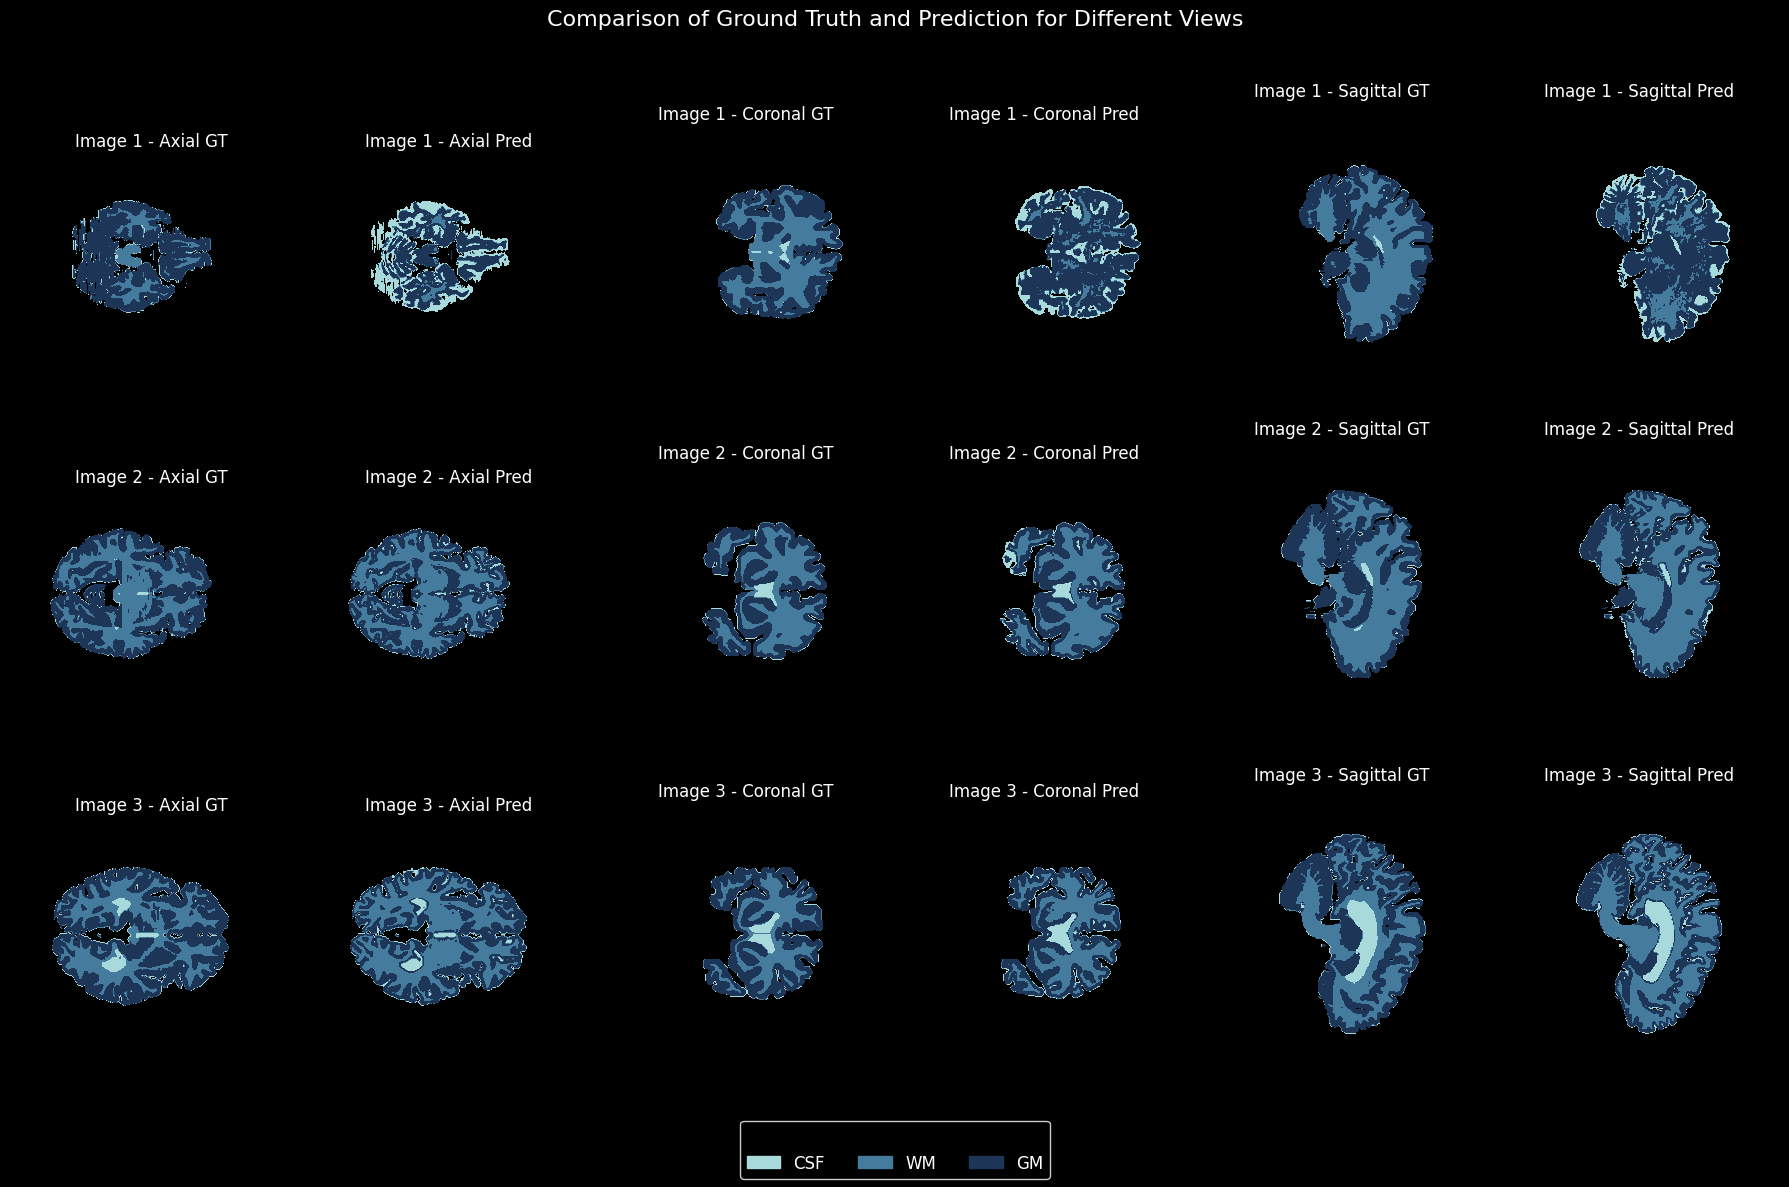

In [7]:
# Initialize the TissueModelSegmentation class
tissue_segmenter = TissueModelSegmentation(vec_images=vec_images, vec_gt=vec_gt, tissue_models_map=tissue_model_map)

# Run segmentation and generate the table of Dice scores
tissue_segmenter.segment_images()
dice_score_table = tissue_segmenter.create_dice_score_table()

# Display the table of Dice scores
print("Dice Score Table:")
dice_score_table

# Plot the boxplot of Dice scores for CSF, WM, and GM
print("Boxplot of Dice Scores:")
tissue_segmenter.plot_dice_score_boxplot()

# Visualize the 3x3 grid comparing ground truth and predicted segmentations across views
print("3x3 Grid Comparison of Ground Truth and Predicted Segmentations:")
tissue_segmenter.plot_comparison_grid()

In [8]:
# Save the Dice score table 
dice_score_table.to_csv('Result\\TM\\dice_score_table.csv', index=False)

In [16]:
# Calculate average Dice scores for each tissue type
avg_wm_dice = np.mean(dice_score_table['WM'])
avg_gm_dice = np.mean(dice_score_table['GM'])
avg_csf_dice = np.mean(dice_score_table['CSF'])

print(f"Average Dice Score for WM: {avg_wm_dice:.4f}")
print(f"Average Dice Score for GM: {avg_gm_dice:.4f}")
print(f"Average Dice Score for CSF: {avg_csf_dice:.4f}")

Average Dice Score for WM: 0.8104
Average Dice Score for GM: 0.7736
Average Dice Score for CSF: 0.2394
